# Laboratorio 8: Random Forest y despliegues

**Duración:** 2 horas  
**Formato:** Implementación, despliegue y competencia  

---

## Portada del equipo

**Integrantes:**
- Erick Yair Aguilar Martinez (Usuario GitHub: Eickyair)
- Roberto Jhoshua Alegre Ventura (Usuario GitHub: AlegreVentura)
- Vania Janet Raya Rios (Usuario GitHub: Vania-Janet)

**Repositorio del equipo:**  
[<https://github.com/usuario/equipoX>](https://github.com/Eickyair)

**Fecha de entrega:**  
31/10/2025

In [11]:
# Primero hagamos importaciones, cargas y configuraciones necesarias
import os, time, json, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cycler
from sklearn.pipeline import Pipeline
import math
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import pickle

# Estilo azul limpio
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True,
    "grid.linestyle": "--",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": False,})
plt.rcParams["axes.prop_cycle"] = cycler(color=[ "#0b5fff", "#1f77b4", "#2a9df4", "#4aa3df", "#78a6f7", "#a8c7ff"])

def plot_bar(x, y, title="", xlabel="", ylabel=""):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    plt.tight_layout(); plt.show()

def plot_hist(series, bins=20, title=""):
    fig, ax = plt.subplots()
    ax.hist(series.dropna().values, bins=bins)
    ax.set_title(title); ax.set_xlabel(series.name); ax.set_ylabel("Frecuencia")
    plt.tight_layout(); plt.show()

def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title); ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=20, ha="right"); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.tight_layout(); plt.show()


In [12]:
# carga de datos
CSV_PATH = "iris_train.csv"  
assert os.path.exists(CSV_PATH), f"No existe el archivo: {CSV_PATH}"
df_raw = pd.read_csv(CSV_PATH)

print("Shape:", df_raw.shape)
display(df_raw.head())

# Validaciones mínimas
assert "target" in df_raw.columns, "El dataset tiene la columna 'target'."

# Copia de trabajo
df = df_raw.copy()

# Eliminar columnas vacías/constantes (si las hubiera)
n_before = df.shape[1]
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
if constant_cols:
    df.drop(columns=constant_cols, inplace=True)
    print("Columnas constantes eliminadas:", constant_cols)

# Duplicados
dup_count = df.duplicated().sum()
if dup_count:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Filas duplicadas eliminadas: {dup_count}")


Shape: (125, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.4,2.9,1.4,0.2,0
1,4.9,2.5,4.5,1.7,2
2,6.8,2.8,4.8,1.4,1
3,4.9,3.1,1.5,0.1,0
4,5.5,2.5,4.0,1.3,1


Filas duplicadas eliminadas: 6


Tipos de datos:


,dtype
sepal length (cm),float64
sepal width (cm),float64
petal length (cm),float64
petal width (cm),float64
target,int64



Valores nulos por columna:


,nulos
petal width (cm),5
sepal length (cm),2
sepal width (cm),2
petal length (cm),1
target,0


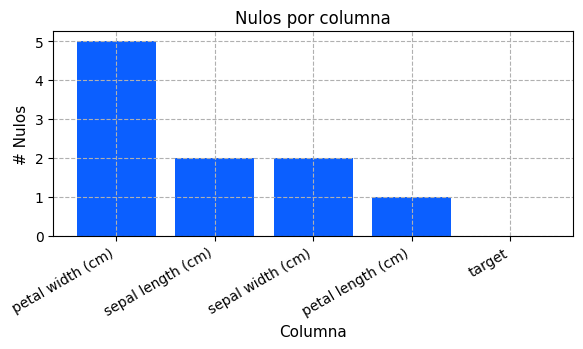

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),117.0,5.833420,2.487019,-11.601111,5.1,5.70,6.4,24.111271
sepal width (cm),117.0,2.760055,2.229421,-14.870849,2.8,3.00,3.3,4.400000
petal length (cm),118.0,3.921519,2.516556,1.100000,1.6,4.25,5.1,23.439238
petal width (cm),114.0,1.185088,0.759044,0.100000,0.3,1.30,1.8,2.500000
target,119.0,0.974790,0.817833,0.000000,0.0,1.00,2.0,2.000000



Outliers por columna (Z, IQR, MAD y Voto 2/3):


,col,out_z,out_iqr,out_mad,out_vote(2/3),pct_vote
0,sepal length (cm),2,2,2,2,1.680672
1,sepal width (cm),2,6,2,2,1.680672
2,petal length (cm),1,1,1,1,0.840336
3,petal width (cm),0,0,0,0,0.000000
4,target,0,0,0,0,0.000000


Filas a eliminar por voto 2/3 en alguna columna: 5 de 119


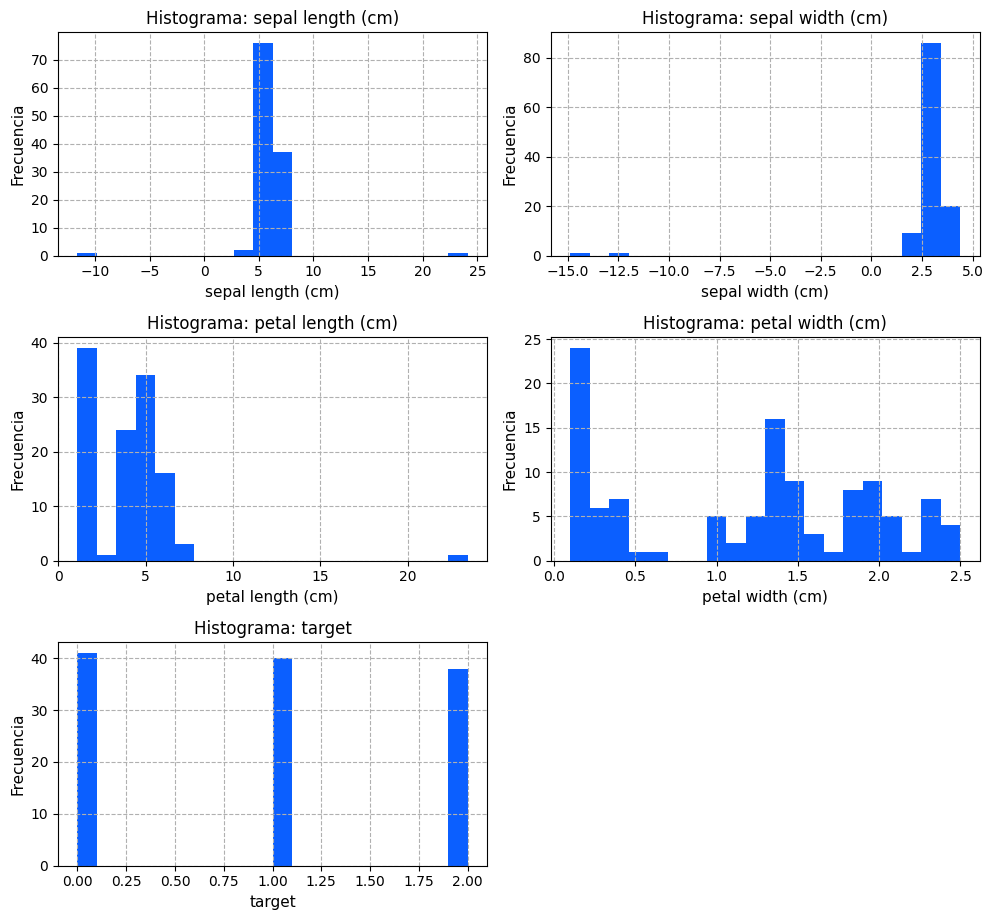

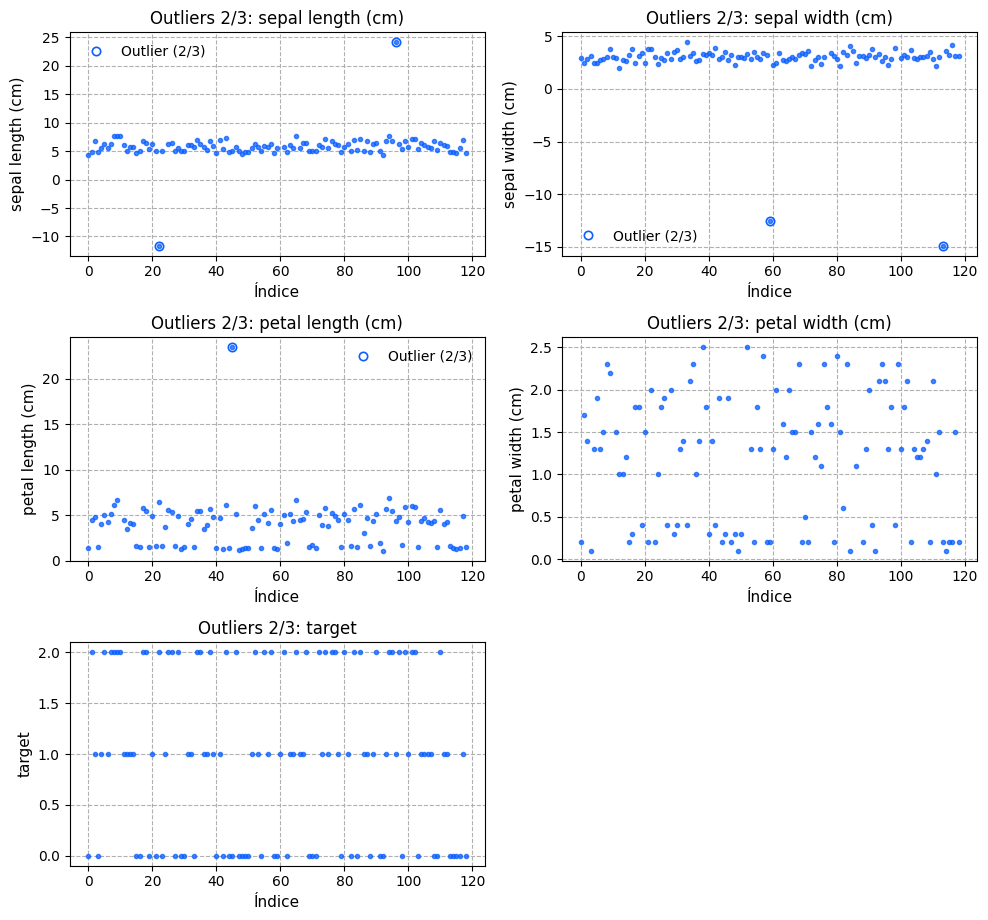

In [13]:
print("Tipos de datos:"); display(pd.DataFrame(df.dtypes, columns=["dtype"]))
print("\nValores nulos por columna:")
na_counts = df.isna().sum().sort_values(ascending=False); display(na_counts.to_frame("nulos"))
fig, ax = plt.subplots(figsize=(max(6, 0.5*len(na_counts)), 3.6))
ax.bar(na_counts.index.astype(str), na_counts.values); ax.set_title("Nulos por columna"); ax.set_xlabel("Columna"); ax.set_ylabel("# Nulos")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right"); plt.tight_layout(); plt.show()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols: display(df[num_cols].describe().T)

# 3 métodos: Z, IQR, MAD; votación 2 de 3
def outlier_vote3(s, z_thr=3.0, iqr_k=1.5, mad_k=3.5):
    x = pd.Series(s).astype(float)
    mu, sd = x.mean(), x.std(ddof=0); z = np.abs((x - mu) / (sd if sd>0 else 1e-12)) > z_thr
    q1, q3 = np.percentile(x.dropna(), [25, 75]); iqr = q3 - q1; low, high = q1 - iqr_k*iqr, q3 + iqr_k*iqr; iqr_m = (x<low)|(x>high)
    med = np.median(x.dropna()); mad = np.median(np.abs(x.dropna() - med)); mad = mad if mad>0 else 1e-12; mad_m = (np.abs(x - med) / (1.4826*mad)) > mad_k
    vote = (z.astype(int) + iqr_m.astype(int) + mad_m.astype(int)) >= 2
    return z.fillna(False).values, iqr_m.fillna(False).values, mad_m.fillna(False).values, vote

stats_rows, vote_by_col = [], {}
for c in num_cols:
    z_m, iqr_m, mad_m, v_m = outlier_vote3(df[c]); vote_by_col[c] = v_m
    n = df[c].size
    stats_rows.append({"col":c, "out_z":int(z_m.sum()), "out_iqr":int(iqr_m.sum()), "out_mad":int(mad_m.sum()),
                       "out_vote(2/3)":int(v_m.sum()), "pct_vote":(v_m.sum()/n)*100 if n else 0.0})
outlier_df = pd.DataFrame(stats_rows).sort_values("pct_vote", ascending=False).reset_index(drop=True)
print("\nOutliers por columna (Z, IQR, MAD y Voto 2/3):"); display(outlier_df)

# Máscara por fila y quitar
row_vote = np.zeros(len(df), dtype=bool)
for c in num_cols: row_vote |= vote_by_col[c]
print(f"Filas a eliminar por voto 2/3 en alguna columna: {int(row_vote.sum())} de {len(df)}")
df_clean = df.loc[~row_vote].copy()

# Histogramas
if num_cols:
    n = len(num_cols); cols = 2; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3.1*rows)); axes = np.atleast_2d(axes)
    for i, c in enumerate(num_cols):
        ax = axes[i//cols, i%cols]; ax.hist(df[c].dropna().values, bins=20)
        ax.set_title(f"Histograma: {c}"); ax.set_xlabel(c); ax.set_ylabel("Frecuencia")
    for j in range(n, rows*cols): axes[j//cols, j%cols].axis("off")
    plt.tight_layout(); plt.show()

# Marcar outliers en gráficos de dispersión
if num_cols:
    n = len(num_cols); cols = 2; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3.1*rows)); axes = np.atleast_2d(axes); idx = np.arange(len(df))
    for i, c in enumerate(num_cols):
        ax = axes[i//cols, i%cols]; yv = df[c].values; vm = vote_by_col[c]
        ax.plot(idx, yv, ".", alpha=0.75); ax.plot(idx[vm], yv[vm], "o", mfc="none", mec="#0b5fff", ms=6, mew=1.2, label="Outlier (2/3)")
        ax.set_title(f"Outliers 2/3: {c}"); ax.set_xlabel("Índice"); ax.set_ylabel(c); 
        if vm.any(): ax.legend()
    for j in range(n, rows*cols): axes[j//cols, j%cols].axis("off")
    plt.tight_layout(); plt.show()


In [14]:
# Preprocesamiento óptimo (IterativeImputer[RF] + Yeo-Johnson + RobustScaler), sin guardado

y = df["target"].to_numpy()
Xdf = df.drop(columns=["target"])

num_cols = Xdf.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = Xdf.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", IterativeImputer(
                estimator=RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
                random_state=42, max_iter=20
            )),
            ("pow", PowerTransformer(method="yeo-johnson")),
            ("rob", RobustScaler()),
        ]), num_cols),
        *([("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]), cat_cols)] if cat_cols else [])
    ],
    remainder="drop", verbose_feature_names_out=False
)

Xtr_df, Xte_df, ytr, yte = train_test_split(Xdf, y, test_size=0.2, stratify=y, random_state=42)
Xtr = preprocessor.fit_transform(Xtr_df)
Xte = preprocessor.transform(Xte_df)

try:
    feat_names = preprocessor.get_feature_names_out()
except Exception:
    feat_names = [f"f{i}" for i in range(Xtr.shape[1])]

print("Listo el preprocesamiento.")
print("Shapes -> Xtr:", Xtr.shape, " Xte:", Xte.shape)
print("NaNs ->", np.isnan(Xtr).sum(), "/", np.isnan(Xte).sum())

Listo el preprocesamiento.
Shapes -> Xtr: (95, 4)  Xte: (24, 4)
NaNs -> 0 / 0


## Elemento 1 - Implementación del Random Forest

In [15]:
class SimpleRandomForest:
    def __init__(self, n_estimators=200, max_features="sqrt", max_depth=None, oob_score=False, random_state=42):
        # Guarda hiperparámetros
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.oob_score = oob_score
        self.random_state = random_state
        # Inicializa estado
        self.trees_ = []
        self.feat_idx_ = []
        self.classes_ = None
        self.oob_score_ = None
        self._rng = np.random.default_rng(random_state)

    def _bootstrap_sample(self, X, y):
        # Toma muestra con reemplazo
        n = X.shape[0]
        idx = self._rng.integers(0, n, size=n)
        if self.oob_score:
            # Calcula índices fuera de bolsa
            all_idx = np.arange(n)
            mask = np.ones(n, dtype=bool)
            mask[idx] = False
            oob_idx = all_idx[mask]
            return X[idx], y[idx], oob_idx
        return X[idx], y[idx], None

    def _feature_subset(self, p):
        # Selecciona subconjunto de variables para el árbol
        if self.max_features == "sqrt":
            k = max(1, int(np.sqrt(p)))
        elif self.max_features in ("all", None):
            k = p
        elif isinstance(self.max_features, float):
            k = max(1, int(round(self.max_features * p)))
        elif isinstance(self.max_features, int):
            k = min(p, max(1, self.max_features))
        else:
            k = p
        return np.sort(self._rng.choice(p, size=k, replace=False))

    def fit(self, X, y):
        # Ajusta el ensamble con bootstrap y submuestreo de variables
        X = np.asarray(X)
        y = np.ravel(np.asarray(y))
        n, p = X.shape

        self.trees_.clear()
        self.feat_idx_.clear()
        self.oob_score_ = None

        # Guarda clases
        self.classes_ = np.unique(y)

        # Prepara semillas y acumuladores OOB
        seeds = self._rng.integers(0, 10_000_000, size=self.n_estimators)
        if self.oob_score:
            oob_sum = {}
            oob_cnt = {}

        for s in seeds:
            Xb, yb, oob_idx = self._bootstrap_sample(X, y)
            feats = self._feature_subset(p)

            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=int(s))
            tree.fit(Xb[:, feats], yb)

            self.trees_.append(tree)
            self.feat_idx_.append(feats)

            # Acumula predicciones OOB
            if self.oob_score and oob_idx.size > 0:
                proba = tree.predict_proba(X[oob_idx][:, feats])
                for i, idx in enumerate(oob_idx):
                    if idx not in oob_sum:
                        oob_sum[idx] = proba[i].copy()
                        oob_cnt[idx] = 1
                    else:
                        oob_sum[idx] += proba[i]
                        oob_cnt[idx] += 1

        # Calcula métrica OOB
        if self.oob_score and len(oob_cnt) > 0:
            idxs = np.array(list(oob_cnt.keys()))
            proba = np.vstack([oob_sum[i] / oob_cnt[i] for i in idxs])
            y_hat = self.classes_[np.argmax(proba, axis=1)]
            self.oob_score_ = float(np.mean(y[idxs] == y_hat))

        return self

    def predict_proba(self, X):
        # Calcula probas promedio del ensamble
        if not self.trees_:
            raise ValueError("El modelo no está ajustado.")
        X = np.asarray(X)
        proba = None
        for t, f in zip(self.trees_, self.feat_idx_):
            p = t.predict_proba(X[:, f])
            proba = p if proba is None else (proba + p)
        proba /= len(self.trees_)
        return proba

    def predict(self, X):
        # Aplica voto duro con desempate por promedios de probas
        if not self.trees_:
            raise ValueError("El modelo no está ajustado.")
        X = np.asarray(X)

        preds = [t.predict(X[:, f]) for t, f in zip(self.trees_, self.feat_idx_)]
        votes = np.vstack(preds).T

        hard = np.array([Counter(row).most_common(1)[0][0] for row in votes])

        # Detecta empates y desempata con voto blando
        ties = []
        for row in votes:
            c = Counter(row)
            top = c.most_common(1)[0][1]
            ties.append(sum(v == top for v in c.values()) > 1)
        ties = np.array(ties, dtype=bool)

        if np.any(ties):
            soft = self.classes_[np.argmax(self.predict_proba(X[ties]), axis=1)]
            hard[ties] = soft

        return hard


,model,n_estimators,max_features,cv_acc_mean,cv_acc_std
0,DecisionTree,1,all,0.873684,0.063158
1,SimpleRF,50,sqrt,0.905263,0.061378
2,SimpleRF,150,sqrt,0.905263,0.061378
3,SimpleRF,300,sqrt,0.905263,0.061378
4,SimpleRF,300,1.0,0.894737,0.057655


Mejor por CV: n_estimators=50, max_features=sqrt
Accuracy test: 0.9167
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         8
  versicolor       0.88      0.88      0.88         8
   virginica       0.88      0.88      0.88         8

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



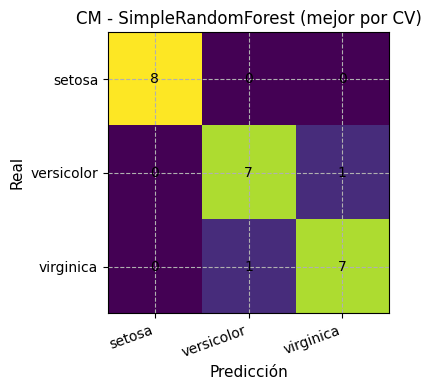

OOB score: 0.9052631578947369


In [16]:
from sklearn.model_selection import StratifiedKFold

# Convierte a numpy
Xtr_np = Xtr.values if hasattr(Xtr, "values") else Xtr
ytr_np = ytr.values if hasattr(ytr, "values") else ytr
Xte_np = Xte.values if hasattr(Xte, "values") else Xte
yte_np = yte.values if hasattr(yte, "values") else yte

SEED = 42
configs = [(50, "sqrt"), (150, "sqrt"), (300, "sqrt"), (300, 1.0)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rows = []

# Evalúa baseline con un árbol
s = []
for tr, va in cv.split(Xtr_np, ytr_np):
    base = DecisionTreeClassifier(random_state=SEED).fit(Xtr_np[tr], ytr_np[tr])
    s.append(accuracy_score(ytr_np[va], base.predict(Xtr_np[va])))
rows.append({"model": "DecisionTree", "n_estimators": 1, "max_features": "all",
             "cv_acc_mean": float(np.mean(s)), "cv_acc_std": float(np.std(s))})

# Evalúa el SimpleRandomForest con diferentes configuraciones
for n, mf in configs:
    s = []
    for tr, va in cv.split(Xtr_np, ytr_np):
        m = SimpleRandomForest(n_estimators=n, max_features=mf, oob_score=True,
                               random_state=SEED).fit(Xtr_np[tr], ytr_np[tr])
        s.append(accuracy_score(ytr_np[va], m.predict(Xtr_np[va])))
    rows.append({"model": "SimpleRF", "n_estimators": n, "max_features": mf,
                 "cv_acc_mean": float(np.mean(s)), "cv_acc_std": float(np.std(s))})

# Ordena resultados
res_cv = pd.DataFrame(rows).sort_values(["model", "cv_acc_mean"], ascending=[True, False]).reset_index(drop=True)
display(res_cv)

# Selecciona el mejor SimpleRF por CV
best = res_cv[res_cv["model"] == "SimpleRF"].sort_values("cv_acc_mean", ascending=False).iloc[0]
print(f"Mejor por CV: n_estimators={int(best.n_estimators)}, max_features={best.max_features}")

# Reentrena con todo el train
rf_best = SimpleRandomForest(n_estimators=int(best.n_estimators),
                             max_features=best.max_features,
                             oob_score=True,
                             random_state=SEED).fit(Xtr_np, ytr_np)

# Predice en test
yp = rf_best.predict(Xte_np)

# Calcula métricas
acc = accuracy_score(yte_np, yp)
print(f"Accuracy test: {acc:.4f}")

# Imprime reporte
try:
    target_names = np.array(["setosa", "versicolor", "virginica"])
    print(classification_report(yte_np, yp, target_names=target_names))
except Exception:
    print(classification_report(yte_np, yp))

# Muestra matriz de confusión
cm = confusion_matrix(yte_np, yp)
try:
    classes = target_names
except Exception:
    classes = np.unique(np.concatenate([yte_np, yp]))
plot_confusion_matrix(cm, classes, "CM - SimpleRandomForest (mejor por CV)")

# Muestra puntaje OOB si aplica
print("OOB score:", rf_best.oob_score_)


In [18]:
# Guardamos el pkl
pkl_dict = dict(
    modelo="SimpleRandomForest",
    accuracy=float(acc),
    precision=float(precision_recall_fscore_support(yte_np, yp, average="weighted", zero_division=0)[0]),
    recall=float(precision_recall_fscore_support(yte_np, yp, average="weighted", zero_division=0)[1]),
    f1=float(precision_recall_fscore_support(yte_np, yp, average="weighted", zero_division=0)[2]),
    cm=cm,
    est=rf_best,                 # estimador entrenado
)

fname = f"modelo.pkl"
with open(fname, "wb") as f:
    pickle.dump(pkl_dict, f)

print("Guardado en:", fname)

Guardado en: modelo.pkl


### Elemento 1 - Preguntas teóricas

- ¿Por qué el bagging ayuda a reducir la varianza del modelo?

  Porque entrenamos muchos modelos en *bootstrap samples* distintas y luego promediamos sus predicciones. Cada modelo individual es ruidoso y tiene alta varianza, pero el promedio “suaviza” los errores. El sesgo mejora, y la varianza cae.

- ¿Qué efecto tiene limitar el número de variables consideradas en cada división?

  Esto fuerza más aleatoriedad en cada árbol: evita que siempre salgan elegidas las mismas variables, disminuye la correlación entre árboles y, por lo tanto, baja la varianza del ensamble. A nivel de cada árbol puede subir un poco el sesgo (porque decide con menos opciones), pero el bosque en conjunto generaliza mejor gracias a la menor correlación entre modelos.

- ¿Cómo cambia el desempeño al incrementar el número de árboles en el ensamble?

  Al agregar más árboles, el error de prueba suele bajar y luego se estabiliz. La varianza del promedio disminuye y converge a un piso determinado. Por otro lado, el costo computacional sí crece linealmente con la cantidad de árboles, así que llega un punto en que agregar más casi no mejora la métrica pero sí aumenta el tiempo.


## Elemento 2 - Comparativa con scikit-learn

In [7]:
# Parámetros
SEED = 42

# Se fija la configuración que dio 23/24 en test
RF_COMMON = dict(n_estimators=300, max_features="sqrt", max_depth=None, random_state=SEED)
RF_SIMPLE = RF_COMMON
RF_SK = dict(n_estimators=300, max_features="sqrt", max_depth=None,
             min_samples_leaf=1, min_samples_split=2, criterion="gini",
             bootstrap=True, random_state=SEED)

# Utilidades
from time import perf_counter as _t
from sklearn import metrics as _m
from sklearn import ensemble as _e

def evaluar_modelo(nombre, modelo, Xtr, ytr, Xte, yte):
    # Mide tiempo y calcula métricas
    t0 = _t(); modelo.fit(Xtr, ytr); t_ent = _t() - t0
    t1 = _t(); ypred = modelo.predict(Xte); t_pred = _t() - t1
    return dict(
        modelo=nombre,
        accuracy=_m.accuracy_score(yte, ypred),
        precision=_m.precision_score(yte, ypred, average="weighted", zero_division=0),
        recall=_m.recall_score(yte, ypred, average="weighted", zero_division=0),
        f1=_m.f1_score(yte, ypred, average="weighted", zero_division=0),
        cm=_m.confusion_matrix(yte, ypred),
        t_entrenamiento_s=t_ent,
        t_prediccion_s=t_pred,
        est=modelo
    )

def plot_confusion(ax, cm, classes, title):
    # Dibuja matriz de confusión
    im = ax.imshow(cm, interpolation="nearest"); ax.set_title(title)
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right"); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")
    return im

def plot_frontera(ax, modelo, X, y, titulo):
    # Traza frontera si el espacio es 2D
    if X.shape[1] != 2:
        ax.set_title(titulo + " no aplica"); ax.axis("off"); return
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25); ax.scatter(X[:, 0], X[:, 1], c=y, s=12)
    ax.set_title(titulo)


In [8]:
# Entrenamiento y evaluación
rf_simple = SimpleRandomForest(**RF_SIMPLE)
rf_sklearn = _e.RandomForestClassifier(**RF_SK)

r_simple = evaluar_modelo("SimpleRandomForest", rf_simple, Xtr, ytr, Xte, yte)
r_sklearn = evaluar_modelo("RandomForestClassifier", rf_sklearn, Xtr, ytr, Xte, yte)

resumen = pd.DataFrame([
    {k: v for k, v in r_simple.items() if k not in ("cm", "est")},
    {k: v for k, v in r_sklearn.items() if k not in ("cm", "est")}
]).set_index("modelo").sort_values("f1", ascending=False)
resumen


,accuracy,precision,recall,f1,t_entrenamiento_s,t_prediccion_s
modelo,,,,,,
SimpleRandomForest,0.958333,0.962963,0.958333,0.958170,0.213941,0.030045
RandomForestClassifier,0.916667,0.933333,0.916667,0.915344,0.235695,0.009978


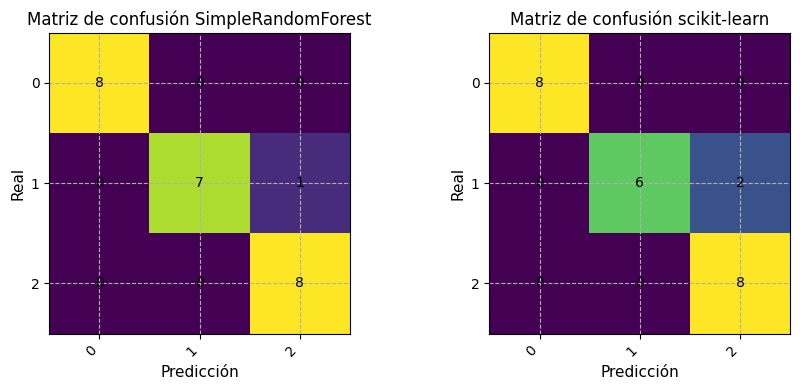

In [9]:
# Confusión
classes = np.sort(np.unique(yte))
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
plot_confusion(ax[0], r_simple["cm"], classes, "Matriz de confusión SimpleRandomForest")
plot_confusion(ax[1], r_sklearn["cm"], classes, "Matriz de confusión scikit-learn")
fig.tight_layout(); plt.show()


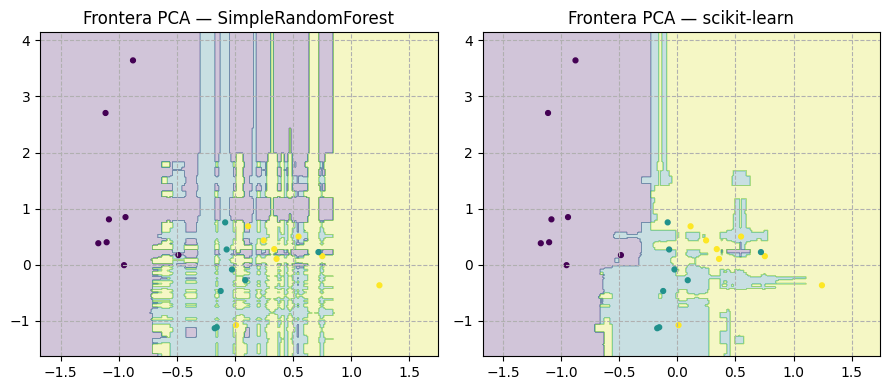

Mejor puntaje por métrica:
accuracy     SimpleRandomForest
precision    SimpleRandomForest
recall       SimpleRandomForest
f1           SimpleRandomForest

Más rápido por etapa:
t_entrenamiento_s        SimpleRandomForest
t_prediccion_s       RandomForestClassifier


In [10]:
# Fronteras (PCA 2D) + Resumen
Xtr_np = Xtr.values if hasattr(Xtr, "values") else Xtr
Xte_np = Xte.values if hasattr(Xte, "values") else Xte

# Se aplica PCA a 2D para visualización
pca = PCA(n_components=2, random_state=SEED)
Xtr2 = pca.fit_transform(Xtr_np)
Xte2 = pca.transform(Xte_np)

rf_simple_2d = SimpleRandomForest(**RF_SIMPLE).fit(Xtr2, ytr)
rf_sklearn_2d = _e.RandomForestClassifier(**RF_SK).fit(Xtr2, ytr)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
plot_frontera(ax[0], rf_simple_2d, Xte2, yte, "Frontera PCA — SimpleRandomForest")
plot_frontera(ax[1], rf_sklearn_2d, Xte2, yte, "Frontera PCA — scikit-learn")
fig.tight_layout(); plt.show()

# Resumen
cmp = resumen[["accuracy", "precision", "recall", "f1", "t_entrenamiento_s", "t_prediccion_s"]]
print("Mejor puntaje por métrica:")
print(cmp.drop(columns=["t_entrenamiento_s", "t_prediccion_s"]).idxmax().to_string())
print("\nMás rápido por etapa:")
print(cmp[["t_entrenamiento_s", "t_prediccion_s"]].idxmin().to_string())


### Elemento 2 - Preguntas teóricas

- ¿Qué diferencias cuantitativas y cualitativas se observan entre tu implementación y la de sklearn?

  Cuantitativamente se vio diferencias en tiempo y en métrica (accuracy/RMSE): `sklearn` entrenó más rápido y, el algoritmo manual, aunque tardó más, obtuvo un puntito mejor de desempeño (como son pocas muestras, acertar uno más cambia mucho las métricas de comportamiento). 

- ¿Cómo influyen los parámetros n_estimators y max_features en el desempeño del modelo?

  `n_estimators`: al aumentar el número de árboles baja la varianza del ensamble y el error de prueba tiende a mejorar hasta saturarse; pasado cierto punto casi no cambia la métrica pero sí sube el costo computacional.  
  `max_features`: al limitar cuántas variables se consideran en cada división crece la aleatoriedad, disminuye la correlación entre árboles y baja la varianza del bosque; sin embargo, cada árbol individual puede volverse un poco más sesgado.

- ¿Por qué el modelo de sklearn suele ser más rápido o más preciso?

  Porque está muy optimizado: usa C/Cython y operaciones vectorizadas, mejores estructuras de datos para evaluar splits, paraleliza con `n_jobs`, y aplica trucos numéricos (cálculo incremental de impuridades, manejo eficiente de categorías/continuas).

- ¿Tu implementación mantiene el mismo comportamiento al modificar la semilla aleatoria?

  Con una semilla fija, los resultados se reproducen (mismo muestreo bootstrap y mismas selecciones de `max_features`). Al cambiar la semilla, la métrica varía un poco entre corridas por la aleatoriedad inherente, pero el patrón global se mantiene: más árboles reducen la varianza y valores razonables de `max_features` dan mejor generalización. Si la variación es muy grande, probablemente nos faltan árboles o el dataset es muy pequeño.


## Elemento 3 - Creación y despliegue de la API

### Elemento 3 - Preguntas teóricas